# Drake Quad PID

In [10]:
import math
import pydot
import matplotlib.pyplot as plt
import mpld3
import numpy as np
from IPython.display import HTML, display, SVG
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    ControllabilityMatrix,
    DiagramBuilder,
    Linearize,
    LinearQuadraticRegulator,
    MeshcatVisualizer,
    MultibodyPlant,
    Parser,
    Propeller,
    PropellerInfo,
    RigidTransform,
    RobotDiagramBuilder,
    Saturation,
    SceneGraph,
    Simulator,
    StartMeshcat,
    WrapToSystem,
    namedview,
)
from pydrake.examples import (
    AcrobotGeometry,
    AcrobotInput,
    AcrobotPlant,
    AcrobotState,
    QuadrotorGeometry,
    QuadrotorPlant,
    StabilizingLQRController,
)
from pydrake.solvers import MathematicalProgram, Solve
import os
from underactuated import ConfigureParser, running_as_notebook
from underactuated.meshcat_utils import MeshcatSliders
from underactuated.quadrotor2d import Quadrotor2D, Quadrotor2DVisualizer
from underactuated.scenarios import AddFloatingRpyJoint

if running_as_notebook:
    mpld3.enable_notebook()

## Visualization Server

In [11]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


In [12]:
from pydrake.all import LeafSystem, BasicVector, PortDataType, AbstractValue
from pydrake.math import RigidTransform, RotationMatrix
from pydrake.multibody.tree import FrameIndex
import numpy as np

class QuaternionOutputSystem(LeafSystem):
    def __init__(self, plant, body_index):
        LeafSystem.__init__(self)
        self.plant = plant
        self.body_index = body_index
        # Assuming the plant context is obtained from a parent diagram at runtime
        self.plant_context = None

        # Declare input port that expects the entire state of the MultibodyPlant
        self.DeclareVectorInputPort("x", BasicVector(plant.num_multibody_states()))

        # Declare output port that provides the quaternion
        self.DeclareVectorOutputPort("quaternion", BasicVector(4), self.CalcQuaternion)

    def CalcQuaternion(self, context, output):
        if self.plant_context is None:
            raise ValueError("Plant context has not been set.")
        # Extract the pose of the body
        body = self.plant.get_body(self.body_index)
        X_WB = self.plant.EvalBodyPoseInWorld(self.plant_context, body)
        # Convert rotation to quaternion
        quaternion = X_WB.rotation().ToQuaternion().wxyz()
        output.SetFromVector(quaternion)

## Make Multibody plant

We use the drake library to import our quad rotor without the propellers. This maintains its inertial properties and mass properties from the urdf file specified.

<img src="images/quad_arm.png" alt="Alt text" width="600"/>

Arm length measurement

In [13]:

def MakeMultibodyQuadrotor():
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.0)
    #plant = builder.AddSystem(MultibodyPlant(0.0))
    #scene_graph = builder.AddSystem(SceneGraph())
    parser = Parser(plant)
    
    # Your relative path
    relative_path = "quad-basev0/quad-base.urdf"
    # Convert to an absolute path
    absolute_path = os.path.abspath(relative_path)
    
    # Use the absolute path here
    (model_instance,) = parser.AddModels(absolute_path)
    
    AddFloatingRpyJoint(
        plant,
        plant.GetFrameByName("base_link"),
        model_instance,
        use_ball_rpy=False,
    )
    plant.Finalize()

    visualizer = MeshcatVisualizer.AddToBuilder(
        builder, scene_graph, meshcat
    )

    body_index = plant.GetBodyByName("base_link").index()

    # Create and add the QuaternionOutputSystem to the diagram
    quaternion_system = QuaternionOutputSystem(plant, body_index)
    builder.AddSystem(quaternion_system)

    # Connect the MultibodyPlant's state output port to the QuaternionOutputSystem's input port
    builder.Connect(plant.get_state_output_port(model_instance),
                    quaternion_system.get_input_port(0))

    L = 0.395 #meters arm length
    kF = 1.0
    kM = 0.0245

    prop_info = [
        PropellerInfo(body_index, RigidTransform([L, 0, 0]), kF, kM),
        PropellerInfo(body_index, RigidTransform([0, L, 0]), kF, -kM),
        PropellerInfo(body_index, RigidTransform([-L, 0, 0]), kF, kM),
        PropellerInfo(body_index, RigidTransform([0, -L, 0]), kF, -kM),
    ]
    propellers = builder.AddSystem(Propeller(prop_info))
    builder.Connect(
        propellers.get_output_port(),
        plant.get_applied_spatial_force_input_port(),
    )
    builder.Connect(
        plant.get_body_poses_output_port(),
        propellers.get_body_poses_input_port(),
    )
    builder.ExportInput(propellers.get_command_input_port(), "u")


    return builder.Build(), plant


In [14]:
mbp_plant, mbp = MakeMultibodyQuadrotor()

### Viewing its diagram

Here we can view the different ports of our imported robot. There are two main types of ports, input ports, and output ports. Input ports are typically for input actuations, output ports are typically for state information such as position velocity and attitude.

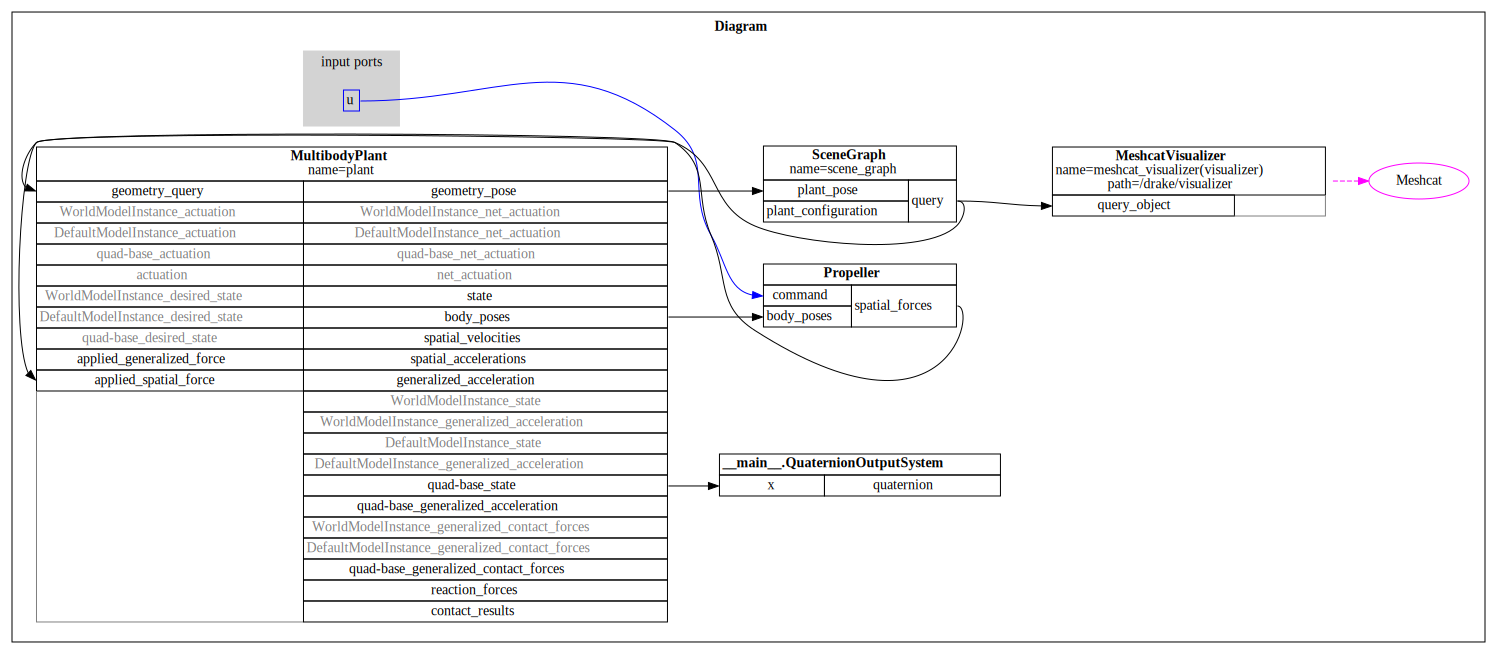

In [15]:
display(
    SVG(
        pydot.graph_from_dot_data(
            mbp_plant.GetGraphvizString(
                max_depth=3))[0].create_svg()))

### Printing important information

In [ ]:
# First, ensure your MultibodyPlant 'mbp' is properly initialized and finalized
# as shown in your MakeMultibodyQuadrotor() function
from pydrake.multibody.tree import BodyIndex, JointIndex

# Information about states and elements
num_positions = mbp.num_positions()
num_velocities = mbp.num_velocities()
num_multibody_states = mbp.num_multibody_states()
num_actuators = mbp.num_actuators()  # Corrected from num_force_elements to num_actuators for clarity
num_force_elements = mbp.num_force_elements()
num_bodies = mbp.num_bodies()
num_joints = mbp.num_joints()
num_model_instances = mbp.num_model_instances()

# Printing the collected information
print(f"Number of position states: {num_positions}")
print(f"Number of velocity states: {num_velocities}")
print(f"Total number of multibody states: {num_multibody_states}")
print(f"Total number of force elements: {num_force_elements}")
print(f"Total number of bodies: {num_bodies}")
print(f"Number of joints: {num_joints}")
print(f"Number of model instances: {num_model_instances}")

# Additional useful information might include details about specific components, like joints and bodies.
# Here's how you could list the names of all bodies and joints in the MultibodyPlant:
print("\nList of all body names:")
for i in range(mbp.num_bodies()):
    body = mbp.get_body(BodyIndex(i))
    print(f"Body {i}: {body.name()}")

print("\nList of all joint names:")
for i in range(mbp.num_joints()):
    joint = mbp.get_joint(JointIndex(i))
    print(f"Joint {i}: {joint.name()}")


# Control (PX4)

We replicate PX4's control structure for position velocity attitude and attitude derivatives

![PX4](images/px4_control.png)

## Basic PID Control

In [21]:
class PIDController(LeafSystem):
    def __init__(self, kp, ki, kd, system_time_step):
        LeafSystem.__init__(self)
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.system_time_step = system_time_step
        self.integral = 0
        self.prev_error = 0

        # Define input, output, and state ports
        self.DeclareVectorInputPort("error", BasicVector(1))
        self.DeclareVectorOutputPort("control_signal", BasicVector(1), self.CalcOutput)
        self.DeclareDiscreteState(1)  # For integral term
        self.DeclarePeriodicDiscreteUpdate(period_sec=system_time_step)

    def DoCalcDiscreteVariableUpdates(self, context, events, discrete_state):
        error = self.EvalVectorInput(context, 0).GetAtIndex(0)
        self.integral += error * self.system_time_step
        discrete_state.get_mutable_vector().SetAtIndex(0, self.integral)

    def CalcOutput(self, context, output):
        error = self.EvalVectorInput(context, 0).GetAtIndex(0)
        integral = context.get_discrete_state_vector().GetAtIndex(0)
        derivative = (error - self.prev_error) / self.system_time_step
        control_signal = self.kp * error + self.ki * integral + self.kd * derivative
        output.SetAtIndex(0, control_signal)
        self.prev_error = error

In [19]:
simulator = Simulator(mbp_plant)
simulator.AdvanceTo(1.0)

RuntimeError: InputPort::Eval(): required InputPort[0] (command) of System ::_::drake/multibody/Propeller@0000561a28076b70 (Propeller<double>) is not connected